In [1]:
from functions import *

$$ z_k = \frac{G}{B} = \left(\frac{\alpha}{1-\alpha}\frac{r^B}{r^G}\right)^{\gamma_s}$$
$$ z_l = \frac{L}{K} =  \frac{1-\beta}{\beta} \frac{1}{\alpha}(\alpha_s + (1-\alpha_s) z_k^{-\frac{\gamma_s-1}{\gamma_s}})^{\frac{1}{\gamma_s-1}} \frac{r^G}{W} $$


$$
\frac{\tilde{A}}{r^B + \tau_E\tilde{A}}\left[
            -\frac{\gamma\alpha}{\circ} 
            - (\dfrac{w}{\frac{r}{z_l} + w})\frac{1-\alpha}{\triangle}
            \right]
$$

In [2]:

def gen_df(params,τ_E):
    params_0 = params.copy()
    params_0['τ_E'] = τ_E 
    params_1 = params_0.copy()
    res_1 = ratios_gen(params_1)
    res_1 = res_1.__add__((res_1[6] *params_1['A_tilde'], ))
    res_1 = res_1.__add__((function_coef(params_1,τ_E), ))
    params_2 = params_0.copy()
    params_2['A_hat'] = params_2['A_hat'] * 0.8
    params_2['A_tilde'] = params_2['A_tilde'] * 1.2
    res_2 = ratios_gen(params_2)
    res_2 = res_2.__add__((res_2[6] *params_2['A_tilde'], ))
    res_2 = res_2.__add__((function_coef(params_2,τ_E), ))
    # put the results into a dataframe
    df = pd.DataFrame([res_1,res_2],columns=['z_k','z_l','l','y','p','g','b','e','coef'])
    df['income'] = (df.y * df.p).round(2)
    df['intensity'] = df.e / df.y / df.p 
    
    # add sum row
    df.loc['sum'] = np.nan
    df.loc['sum','l']= df.l.sum()
    df.loc['sum','g']= df.g.sum()
    df.loc['sum','b']= df.b.sum()
    df.loc['sum','e']= df.e.sum()
    df.loc['sum','income']= df.income.sum()
    p_s = 0
    y_s = 0
    for i in [res_1,res_2]:
        p_s += i[4] ** (1-params_0['σ'])
        y_s += i[3] ** ((params_0['σ']-1)/(params_0['σ']))
    p_s = p_s ** (1/(1-params_0['σ']))
    y_s = y_s ** (params_0['σ']/(params_0['σ']-1))
    df.loc['sum','p'] = p_s
    # df.p = df.p/p_s
    df.loc['sum','y'] = y_s
    return df
def function_coef(parameters,τ_E):
    A_tilde = parameters['A_tilde']
    α = parameters['α']
    γ = parameters['γ']
    z_l, z_k =  optimal_ratios(parameters,τ_E)
    green_premium = parameters['green_premium']
    r_b = parameters['r_b']
    w = parameters['w']
    β = parameters['β']
    r = function_r(α,γ,z_k,green_premium,r_b)
    if τ_E == 0:
        return 0
    else:
        epsilon_change = A_tilde/(r_b + τ_E/1000 * A_tilde) * (
        -γ*α/(function_green_ratio(α,γ,z_k) ** (-((γ-1)/γ))) - (1-α)/(function_green_ratio(α,γ,z_k) ** (-((γ-1)/γ)))*(2*β - (1+(r/z_l)/(r/z_l + w) )
        ))
        # epsilon_change = A_tilde/(r_b + τ_E/1000 * A_tilde) * (
        # -γ*α/(function_green_ratio(α,γ,z_k) ** (-((γ-1)/γ))) - (1-α)/(function_green_ratio(α,γ,z_k) ** (-((γ-1)/γ)))/(function_r(α,γ,z_k,green_premium,r_b) /w/z_l) 
        # )
        c_change = 1/(τ_E/1000) + epsilon_change
        return epsilon_change/c_change 
def function_K(g,b,α,γ):
    return (α * g ** ((γ-1)/γ) + (1-α) * b ** ((γ-1)/γ)) ** (γ/(γ-1))

In [3]:
parameters = {
    'β': 0.6,
    'γ':2.58,
    'α': 0.25,
    'A_hat':2,
    'A_tilde': .0002,
    'μ': 0,
    'θ': 1,
    'η': np.inf,
    'σ': 5,
    'r_b': 0.05,
    'green_premium': 0,
    'w': .500, # MSEK
    'τ_E': 0,# per ton
    'n': int(1e3),
    'sd_hat': .45,
    'sd_tilde': 2,
    'rho': .9,
    }

# CO2 Emission is 13800 Kton
# Labor 500 TSEK

tax_1 = 0
tax_2 = 100
tax_3 = 1300
df = pd.concat([gen_df(parameters,tax_1),gen_df(parameters,tax_2),gen_df(parameters,tax_3)],keys=['τ_E = {}'.format(tax_1),'τ_E = {}'.format(tax_2),'τ_E = {}'.format(tax_3)],axis=0)
print(1- df.loc[df.index == ('τ_E = {}'.format(tax_3), 'sum')].e.iloc[0]/ df.loc[df.index == ('τ_E = 0', 'sum')].e.iloc[0] , 1- df.loc[df.index == ('τ_E = {}'.format(tax_3), 'sum')].y.iloc[0]/ df.loc[df.index == ('τ_E = 0', 'sum')].y.iloc[0] )
df

0.9974958203066522 0.9861249982820247


z_k       z_l          l           y         p  \
τ_E = 0    0    0.058753  0.102856  40.333701  315.762185  0.199585   
           1    0.058753  0.102856  16.520684  103.468953  0.249481   
           sum       NaN       NaN  56.854384  484.986872  0.183170   
τ_E = 100  0    0.139971  0.140559  19.061660  123.730264  0.240716   
           1    0.161548  0.147812   6.919578   34.863783  0.310117   
           sum       NaN       NaN  25.981238  182.221589  0.222782   
τ_E = 1300 0    6.507253  0.419818   1.379346    4.643724  0.464116   
           1    9.708512  0.450680   0.476537    1.229972  0.605370   
           sum       NaN       NaN   1.855882    6.729194  0.430931   

                        g           b         e      coef  income  intensity  
τ_E = 0    0    33.573143  571.432365  0.114286  0.000000   63.02   0.001813  
           1    13.751559  234.058697  0.056174  0.000000   25.81   0.002176  
           sum  47.324702  805.491062  0.170461       NaN   88.83        NaN  
τ_E = 100  0    25.988247  185.669040  0.037134 -0.000058   29.78   0.001247  
           1    10.214558   63.229125  0.015175 -0.000077   10.81   0.001404  
           sum  36.202805  248.898166  0.052309       NaN   40.59        NaN  
τ_E = 1300 0    10.595230    1.628218  0.000326 -0.002637    2.16   0.000151  
           1     4.094573    0.421751  0.000101 -0.003306    0.74   0.000136  
           sum  14.689802    2.049969  0.000427       NaN    2.90        NaN

In [33]:
# function_K(g,b,α,γ):
function_K(2.19,37.29,0.25,2.58)*0.102856
# production_function(A_hat,β,z_l,L)

2.6319983061714427

In [26]:
parameters = {
    'β': 0.6,
    'γ':2.58,
    'α': 0.25,
    'A_hat':2,
    'A_tilde': .2,
    'μ': 0,
    'θ': 1,
    'η': np.inf,
    'σ': 5,
    'r_b': 0.05,
    'green_premium': 0,
    'w': .500, # MSEK
    'τ_E': 0,# per ton
    'n': int(1e3),
    'sd_hat': .45,
    'sd_tilde': 2,
    'rho': .9,
    }

res = simulate_firms(parameters)

emissions,production,intensity,emission_cost,G_c,B_c,l,income,cost_share,price = res[0],res[1],res[2],res[3],res[4],res[5],res[6],res[7],res[8],res[9]
z_k_ratios = res[10]
z_l_ratios = res[11]
K = res[12]
Y = CES_aggregator(production,parameters['σ'])
e = sum(emissions)

res_dict = {
    'emissions': {'mean': emissions.mean(), 'median': np.median(emissions) ,'std': emissions.std(), 'sum': sum(emissions)},
    'production': {'mean': production.mean(), 'median': np.median(production) ,'std': production.std(), 'sum': Y},
    'intensity': {'mean': intensity.mean(), 'median': np.median(intensity) ,'std': intensity.std(), 'sum': np.nan}, 
    'emission_cost': {'mean': emission_cost.mean(), 'median': np.median(emission_cost) ,'std': emission_cost.std(), 'sum': sum(emission_cost)},
    'G_c': {'mean': G_c.mean(), 'median': np.median(G_c) ,'std': G_c.std(), 'sum': sum(G_c)},
    'B_c': {'mean': B_c.mean(), 'median': np.median(B_c) ,'std': B_c.std(), 'sum': sum(B_c)},
    'K': {'mean': K.mean(), 'median': np.median(K) ,'std': K.std(), 'sum': sum(K)},
    'l': {'mean': l.mean(), 'median': np.median(l) ,'std': l.std(), 'sum': sum(l)},
    'income': {'mean': income.mean(),'median': np.median(income), 'std': income.std(), 'sum': sum(income)},
    'cost_share': {'mean': cost_share.mean(),'median': np.median(cost_share), 'std': cost_share.std(), 'sum': sum(cost_share)},
    'price': {'mean': price.mean(),'median': np.median(price), 'std': price.std(), 'sum': np.nan},
    'z_k': {'mean': z_k_ratios.mean(),'median': np.median(z_k_ratios), 'std': z_k_ratios.std(), 'sum': np.nan},
    'z_l': {'mean': z_l_ratios.mean(),'median': np.median(z_l_ratios), 'std': z_l_ratios.std(), 'sum': np.nan},

}
res_df = pd.DataFrame(res_dict).T
#hist plot
# plt.figure()
# plt.hist(l,bins=100)
# plt.show()
res_df

,mean,median,std,sum
emissions,18648.411563,7.318750,4.705325e+05,1.864841e+07
production,353407.327703,21035.026259,3.133609e+06,1.126474e+09
intensity,0.019442,0.001917,1.507265e-01,NaN
emission_cost,0.000000,0.000000,0.000000e+00,0.000000e+00
G_c,13.515000,2.227376,6.798246e+01,1.351500e+04
B_c,230.032343,37.911098,1.157097e+03,2.300323e+05
K,2418.724122,398.624325,1.216654e+04,2.418724e+06
l,248.780448,41.000930,1.251403e+03,2.487804e+05
income,25369.514905,4181.091038,1.276124e+05,2.536951e+07
cost_share,0.000000,0.000000,0.000000e+00,0.000000e+00


In [21]:
ratios_gen(parameters)


(0.0587526098031209,
 0.1028560660227717,
 40.333700525940536,
 20608.0078370386,
 0.19958503574860087,
 2.1911287080033723,
 37.29415110827946)

Text(0.5, 1.0, 'A_tilde distribution')

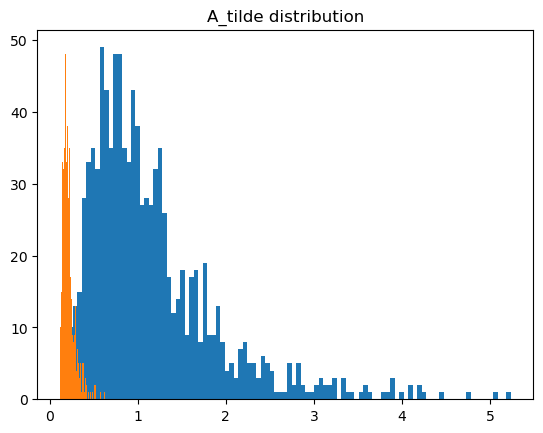

In [5]:
test = np.random.lognormal(mean=0,sigma=.6,size=1000)
A_tilde_vector = (1 + test) * 0.1
#hist plot
plt.figure()
plt.hist(test,bins=100)
plt.hist(A_tilde_vector,bins=100)
plt.title("A_tilde distribution")


In [57]:
parameters_0

{'β': 0.6,
 'γ': 2,
 'α': 0.25,
 'A_hat': 2,
 'A_tilde': 0.2,
 'μ': 0,
 'θ': 1,
 'η': inf,
 'σ': 5,
 'r_b': 0.05,
 'green_premium': 0,
 'w': 0.5,
 'τ_E': 1000,
 'n': 1000,
 'sd_hat': 0.45,
 'sd_tilde': 1,
 'rho': 0.9}

2.319196006015702

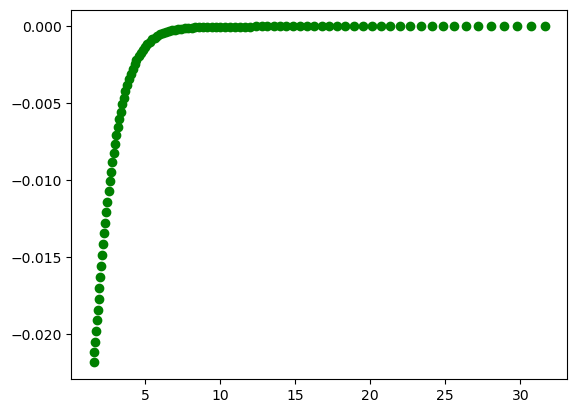

In [18]:
τ_E = 10
params_0 = parameters.copy()
params_0['τ_E'] = τ_E
x_test = []
y_test = []
k_test = []
l_test = []
import matplotlib.pyplot as plt

for i in np.logspace(0.2,1.5,100):
    params_0['γ'] = i
    z_k,z_l = optimal_ratios(params_0,τ_E)
    coef = function_coef(params_0['A_tilde'],params_0['α'],params_0['γ'],z_l,z_k,params_0['green_premium'],params_0['r_b'],params_0['τ_E'],params_0['w'],params_0['β'])
    if ~np.isnan(coef):
        x_test.append(i)
        y_test.append(coef)
# 
fig, ax1 = plt.subplots()

ax1.scatter( x_test,y_test,color='g',label=False)
# fig.legend(['z_k','z_l','Price'])
plt.show()

In [167]:
def test_func(params_0):
    z_k = function_z_k(params_0['α'],params_0['γ'],params_0['r_b'], params_0['green_premium'],params_0['τ_E'],params_0['A_tilde'])
    z_l = function_z_l(z_k,params_0['β'],params_0['α'],params_0['γ'],params_0['w'],params_0['green_premium'],params_0['r_b'])
    l = optimal_labor(params_0['A_tilde'],params_0['A_hat'],params_0['α'],params_0['γ'],z_l,z_k,params_0['β'],params_0['w'],params_0['green_premium'],params_0['r_b'],params_0['σ'],params_0['τ_E'])
    y = production_function(params_0['A_hat'],params_0['β'],z_l,l)
    p = function_price(params_0['A_tilde'],params_0['A_hat'],params_0['α'],params_0['γ'],z_l,z_k,params_0['β'],params_0['w'],params_0['green_premium'],params_0['r_b'],params_0['σ'],params_0['τ_E'])
    C_G,C_B,c_L,C_E = function_price_detail(params_0['A_tilde'],params_0['A_hat'],params_0['α'],params_0['γ'],z_l,z_k,params_0['β'],params_0['w'],params_0['green_premium'],params_0['r_b'],params_0['σ'],params_0['τ_E'])
    return z_k,z_l,l,y*1e3,p,C_G,C_B,c_L,C_E

params_0 = params.copy()
params_0['σ'] = 5
params_0['w'] = params_0['w'] / 1e3
params_0['τ_E'] = 20 * 1e2
z_k,z_l,l,y,p,C_G,C_B,c_L,C_E = test_func(params_0)
print("C_G:", C_G)
print("C_B:", C_B)
print("c_L:", c_L)
print("C_E:", C_E)
print("P: ",params_0['σ']/(params_0['σ']-1) * (C_G + C_B + c_L + C_E) / params_0['A_hat'])





C_G: 0.03250359679419391
C_B: 0.01863539549533783
c_L: 1.1337234725274548
C_E: 0.013417484756643235
P:  14.978499369670372
